# QDレーザ 日足

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import psar

In [3]:
code = '6613'
symbol = '%s.T' % code
ticker = yf.Ticker(symbol)

In [4]:
# 日足で過去 2 年分のデータを取得
df0 = ticker.history(period='2y', interval='1d')
 
# ローソク足のチャートには、そのうち過去 1 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=365)
df = df0[df0.index >= dt_last - tdelta_1y]
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-02 00:00:00+09:00,301.0,301.0,293.0,293.0,150000,0.0,0.0
2025-04-03 00:00:00+09:00,277.0,285.0,275.0,285.0,177300,0.0,0.0


## 日足チャートとパラボリック SAR

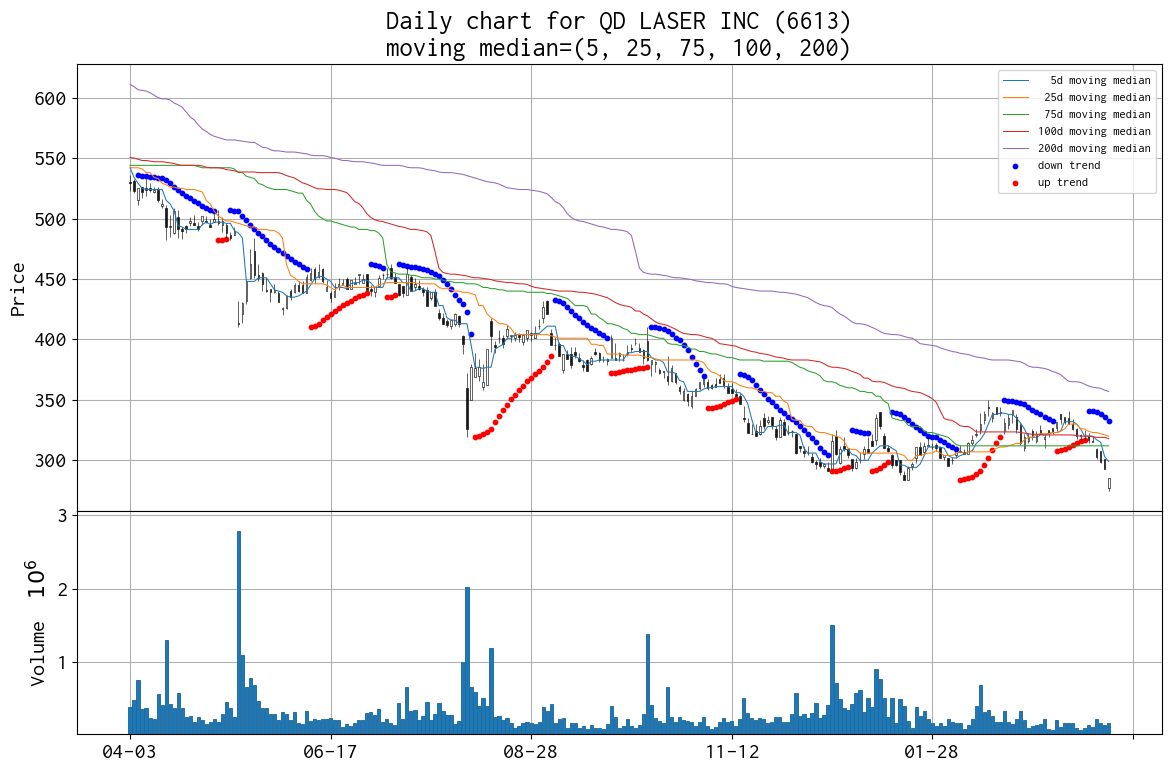

In [5]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d moving median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d moving median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d moving median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d moving median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d moving median', ax=ax[0]),
    mpf.make_addplot(dict_psar['bear'], type='scatter', marker='o', markersize=10, color='blue', label='down trend', ax=ax[0]),
    mpf.make_addplot(dict_psar['bull'], type='scatter', marker='o', markersize=10, color='red', label='up trend', ax=ax[0]),
] 

mpf.plot(df, type='candle', style='default', volume=ax[1], datetime_format='%m-%d', addplot=apds, xrotation=0, ax=ax[0])

try:
    ax[0].set_title('Daily chart for %s (%s)\nmoving median=(5, 25, 75, 100, 200)' % (ticker.info['shortName'], code))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmoving median=(5, 25, 75, 100, 200)' % code)

ax[0].legend(loc='best', fontsize=9)


plt.tight_layout()
plt.savefig('daily_chart_%s.png' % code)
plt.show()

In [6]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-03 00:00:00+09:00,277.0,285.0,275.0,285.0,177300,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-04-02 00:00:00+09:00    293.0
2025-04-03 00:00:00+09:00    285.0
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-04-02 00:00:00+09:00    NaN
2025-04-03 00:00:00+09:00   -8.0
Name: Close, dtype: float64

In [9]:
df['Close'].rolling(5).median().tail(2)

Date
2025-04-02 00:00:00+09:00    303.0
2025-04-03 00:00:00+09:00    299.0
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(25).median().tail(2)

Date
2025-04-02 00:00:00+09:00    321.0
2025-04-03 00:00:00+09:00    320.0
Name: Close, dtype: float64

## Robust Bollinger's bands

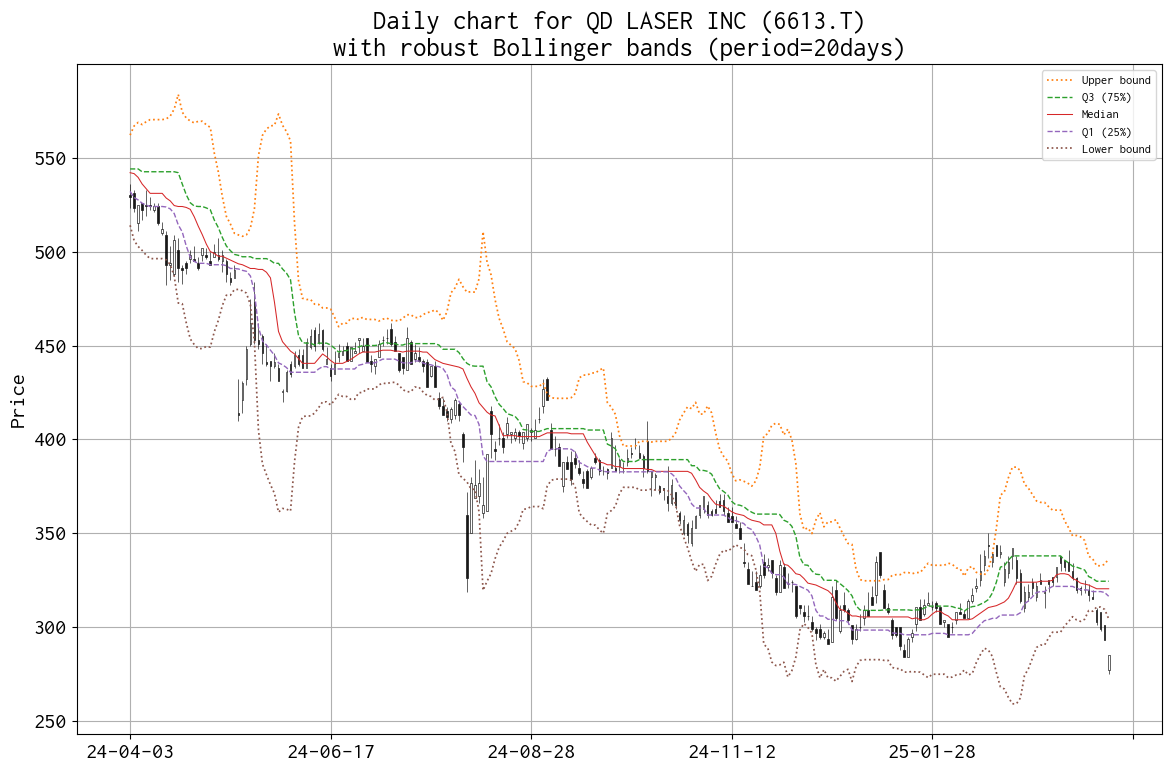

In [11]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%ddays)' % (ticker.info['shortName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%ddays)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

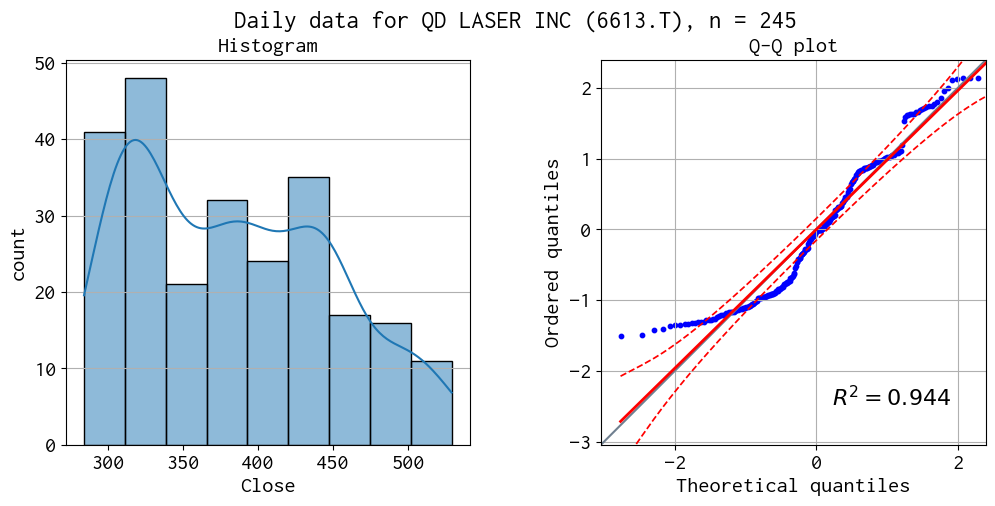

In [12]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['shortName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()